In [2]:
import numpy as np
import pandas as pd
import duckdb

In [2]:
%%time

train_path = '/mnt/isilon/wang_lab/pengwang/projects/Belka/train.parquet'
test_path = '/mnt/isilon/wang_lab/pengwang/projects/Belka/test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT id, molecule_smiles, protein_name, binds
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 1000)
                        UNION ALL
                        (SELECT id, molecule_smiles, protein_name, binds
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 1000)""").df()

con.close()

CPU times: user 1min 8s, sys: 4.56 s, total: 1min 13s
Wall time: 9.4 s


In [3]:
smiles=df['molecule_smiles']
y=df['binds']

In [3]:
import torch
from rdkit import Chem

In [5]:
molecules = [Chem.MolFromSmiles(x) for x in smiles]

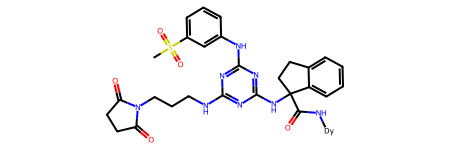

In [6]:
molecules[0]

In [7]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

In [8]:
molecules[0].GetAtoms()

In [9]:
molecules[0].GetBonds()

In [10]:
def generate_graph_from_mol(molecule):
    G = nx.Graph()
    for atom in molecule.GetAtoms():
        G.add_node(atom.GetIdx(),
                   x=torch.tensor([
                       atom.GetAtomicNum(),
                       atom.GetFormalCharge(),
                       atom.GetChiralTag().real,
                       atom.GetHybridization().real,
                       atom.GetNumExplicitHs(),
                       atom.GetNumImplicitHs()],
                       dtype=torch.float))

    bond_type_to_int = {Chem.rdchem.BondType.SINGLE: 0,
                        Chem.rdchem.BondType.DOUBLE: 1,
                        Chem.rdchem.BondType.TRIPLE: 2,
                        Chem.rdchem.BondType.AROMATIC: 3}
    for bond in molecule.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(),
                   edge_attr=torch.tensor([
                       bond_type_to_int[bond.GetBondType()]], dtype=torch.float))

    #Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a :class:`torch_geometric.data.Data` instance.
    #data = from_networkx(G, group_node_attrs=['x'], group_edge_attrs=['edge_attr'])
    return G

In [11]:
graph=generate_graph_from_mol(molecules[0])

In [12]:
graph

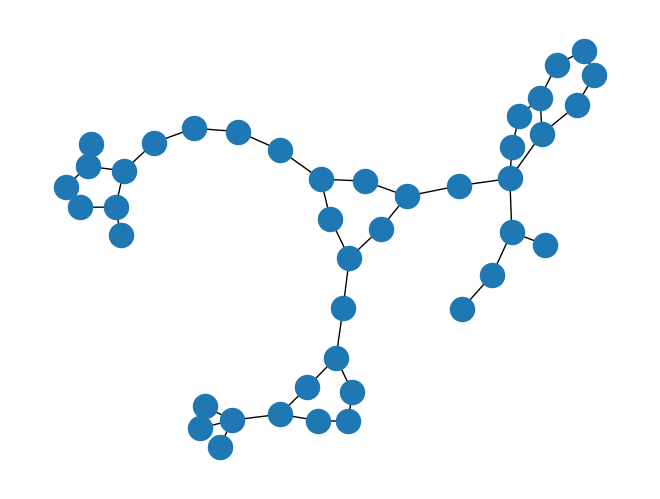

In [13]:
nx.draw(graph)

# Leash Tutorial Molecule Graph and GNN

In [2]:
df = pd.read_csv('/mnt/isilon/wang_lab/shared/Belka/analysis/train_1M_even_dataset.csv')
#df

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,28664519,COc1c(F)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Cc1cc(C#N)c(N)s1,Cc1nc(Cl)c(N)c(Cl)n1,COc1c(F)ccc(C(=O)N[Dy])c1Nc1nc(Nc2sc(C)cc2C#N)...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x155388e7e180>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,20207308,CCC(C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Cl.NCCCNC(=O)C1CCC1,Cc1nnc(N)o1,CCC(C)C(Nc1nc(NCCCNC(=O)C2CCC2)nc(Nc2nnc(C)o2)...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x15540143b450>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,207765966,O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2...,NCCC1CSC1,CC(C)CC(C)(CN)NC(=O)c1cc(Cl)c(Cl)[nH]1.Cl,CC(C)CC(C)(CNc1nc(NCCC2CSC2)nc(Nc2cccc(-c3cccc...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x15540143b760>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,30702711,COc1cc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3ccccc32)cn1,COC(=O)c1nccnc1N,Cc1cc(C)c(CN)c(=O)[nH]1.Cl,COC(=O)c1nccnc1Nc1nc(NCc2c(C)cc(C)[nH]c2=O)nc(...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x15540143b7d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,24419057,CCc1cccc(NC(=O)OCC2c3ccccc3-c3ccccc32)c1C(=O)O,Cc1sc(CCN)nc1-c1ccccc1.Cl.Cl,Cc1cccc(N)c1Cl,CCc1cccc(Nc2nc(NCCc3nc(-c4ccccc4)c(C)s3)nc(Nc3...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x15540143b840>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
1999995,83153156,O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...,Cc1cc(F)ncc1CN,Nc1nc2ccc(Cl)cc2o1,Cc1cc(F)ncc1CNc1nc(NC[C@H]2CC[C@H](C(=O)N[Dy])...,sEH,1,<rdkit.Chem.rdchem.Mol object at 0x1553e6bdb990>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1999996,253752661,O=C(O)C[C@@H](Cc1ccccc1Cl)NC(=O)OCC1c2ccccc2-c...,Nc1cccc2ncccc12,Nc1nnn[nH]1,O=C(C[C@@H](Cc1ccccc1Cl)Nc1nc(Nc2nnn[nH]2)nc(N...,HSA,1,<rdkit.Chem.rdchem.Mol object at 0x1553e6bdba00>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1999997,22466862,CCOc1cc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(Cl)cc1C...,Cl.Nc1ccc(O)cc1Cl,NCCS(=O)Cc1ccccc1,CCOc1cc(Nc2nc(NCCS(=O)Cc3ccccc3)nc(Nc3ccc(O)cc...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x1553e6bdba70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1999998,41545785,CS(=O)(=O)c1ccc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3...,CN1CC(CCN)CC1=O,NCc1ccon1,CN1CC(CCNc2nc(NCc3ccon3)nc(Nc3cc(S(C)(=O)=O)cc...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x1553e6bdbae0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [2]:
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [8]:
%%time
import duckdb
import pandas as pd

train_path = '/mnt/isilon/wang_lab/pengwang/projects/Belka/train.parquet'
test_path = '/mnt/isilon/wang_lab/pengwang/projects/Belka/test.parquet'

con = duckdb.connect()

# Define the number of samples you want per category (binders and non-binders) per protein
samples_per_category = 1000

def get_balanced_data_for_protein(file_path, protein, samples):
    """
    Fetches a balanced dataset for a specific protein.
    
    Parameters:
    - file_path: Path to the dataset file.
    - protein: The name of the protein.
    - samples: Number of samples per binder category (1 or 0).
    
    Returns:
    - A pandas DataFrame containing the balanced dataset for the protein.
    """
    query = f"""
    (SELECT * FROM parquet_scan('{file_path}')
     WHERE binds = 0 AND protein_name = '{protein}'
     ORDER BY random()
     LIMIT {samples})
    UNION ALL
    (SELECT * FROM parquet_scan('{file_path}')
     WHERE binds = 1 AND protein_name = '{protein}'
     ORDER BY random()
     LIMIT {samples})
    """
    return con.query(query).df()


proteins = ['sEH', 'BRD4', 'HSA']

'''datasets = {}
for protein in proteins:
    datasets[protein] = get_balanced_data_for_protein(train_path, protein, samples_per_category)

# At this point, `datasets` contains separate dataframes for sEH, BRD4, and HSA
seh_df = datasets['sEH']
brd4_df = datasets['BRD4']
hsa_df = datasets['HSA']
'''

CPU times: user 7.42 ms, sys: 3.72 ms, total: 11.1 ms
Wall time: 11.8 ms


"datasets = {}\nfor protein in proteins:\n    datasets[protein] = get_balanced_data_for_protein(train_path, protein, samples_per_category)\n\n# At this point, `datasets` contains separate dataframes for sEH, BRD4, and HSA\nseh_df = datasets['sEH']\nbrd4_df = datasets['BRD4']\nhsa_df = datasets['HSA']\n"

In [11]:
def get_data_for_protein(file_path, protein):
    """
    Fetches the dataset for a specific protein from the test dataset.
    
    Parameters:
    - file_path: Path to the dataset file.
    - protein: The name of the protein.
    
    Returns:
    - A pandas DataFrame containing the dataset for the protein.
    """
    query = f"""
    SELECT * FROM parquet_scan('{file_path}')
    WHERE protein_name = '{protein}'
    """
    return con.query(query).df()

con = duckdb.connect()
# Creating a dictionary to store the filtered test datasets
test_datasets = {}
for protein in proteins:  # Using the same list of proteins: ['sEH', 'BRD4', 'HSA']
    test_datasets[protein] = get_data_for_protein(test_path, protein)

# At this point, `test_datasets` contains separate dataframes for sEH, BRD4, and HSA without balancing
# For example, to access the test dataset for sEH:
seh_test_df = test_datasets['sEH']

# And similarly for BRD4 and HSA
brd4_test_df = test_datasets['BRD4']
hsa_test_df = test_datasets['HSA']
con.close()

In [15]:
df=df[['id','molecule_smiles','protein_name','binds','molecule']]

In [17]:
seh_df=df[df['protein_name']=='sEH']
brd4_df = df[df['protein_name']=='BRD4']
hsa_df = df[df['protein_name']=='HSA']

In [18]:
# Atom Featurisation
## Auxiliary function for one-hot enconding transformation based on list of
##permitted values

def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

#Main atom feat. func

def get_atom_features(atom, use_chirality=True):
    # Define a simplified list of atom types
    permitted_atom_types = ['C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I','Dy', 'Unknown']
    atom_type = atom.GetSymbol() if atom.GetSymbol() in permitted_atom_types else 'Unknown'
    atom_type_enc = one_hot_encoding(atom_type, permitted_atom_types)
    
    # Consider only the most impactful features: atom degree and whether the atom is in a ring
    atom_degree = one_hot_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 'MoreThanFour'])
    is_in_ring = [int(atom.IsInRing())]
    
    # Optionally include chirality
    if use_chirality:
        chirality_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_features = atom_type_enc + atom_degree + is_in_ring + chirality_enc
    else:
        atom_features = atom_type_enc + atom_degree + is_in_ring
    
    return np.array(atom_features, dtype=np.float32)

In [19]:
# Bond featurization

def get_bond_features(bond):
    # Simplified list of bond types
    permitted_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC, 'Unknown']
    bond_type = bond.GetBondType() if bond.GetBondType() in permitted_bond_types else 'Unknown'
    
    # Features: Bond type, Is in a ring
    features = one_hot_encoding(bond_type, permitted_bond_types) \
               + [int(bond.IsInRing())]
    
    return np.array(features, dtype=np.float32)

In [20]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, ids, y=None):
    data_list = []
    
    for index, smiles in enumerate(x_smiles):
        mol = Chem.MolFromSmiles(smiles)
        
        if not mol:  # Skip invalid SMILES strings
            continue
        
        # Node features
        atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
        x = torch.tensor(atom_features, dtype=torch.float)
        
        # Edge features
        edge_index = []
        edge_features = []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_index += [(start, end), (end, start)]  # Undirected graph
            bond_feature = get_bond_features(bond)
            edge_features += [bond_feature, bond_feature]  # Same features in both directions
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
        
        # Creating the Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.molecule_id = ids[index]
        if y is not None:
            data.y = torch.tensor([y[index]], dtype=torch.float)
        
        data_list.append(data)
    
    return data_list


In [21]:
from tqdm import tqdm
def featurize_data_in_batches(smiles_list, labels_list, batch_size):
    data_list = []
    # Define tqdm progress bar
    pbar = tqdm(total=len(smiles_list), desc="Featurizing data")
    for i in range(0, len(smiles_list), batch_size):
        smiles_batch = smiles_list[i:i+batch_size]
        labels_batch = labels_list[i:i+batch_size]
        ids_batch = ids_list[i:i+batch_size]
        batch_data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles_batch, ids_batch, labels_batch)
        data_list.extend(batch_data_list)
        pbar.update(len(smiles_batch))
        
    pbar.close()
    return data_list

In [21]:
smile=seh_df['molecule_smiles'][0]
smile

'Cc1cnc(O)c(Nc2nc(NCc3nc(C)c(C)s3)nc(Nc3c(I)cccc3C(=O)N[Dy])n2)c1'

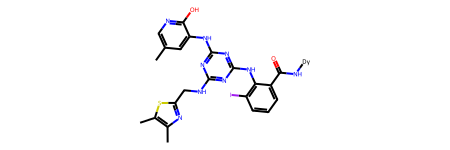

In [22]:
mol=Chem.MolFromSmiles(smile)
mol

### atom feacturization example

In [23]:
print('Num of total atoms in molecule:',len(mol.GetAtoms()))
for i in range(len(mol.GetAtoms())):
    if i <=2 or i==6:
        print('*'*10+f'Atom {i} in molecule'+'*'*10)
        atom = mol.GetAtoms()[i]
        ##The degree of an atom is defined to be 
        ##its number of directly-bonded neighbors.
        print('index:',atom.GetIdx(), #->one hot encode
        '\tdegree:',atom.GetDegree(), #->one hot encode
        '\tsymbol:',atom.GetSymbol(), #->one hot encode
        '\tring:',atom.IsInRing() #->one hot encode
             )

Num of total atoms in molecule: 36
**********Atom 0 in molecule**********
index: 0 	degree: 1 	symbol: C 	ring: False
**********Atom 1 in molecule**********
index: 1 	degree: 3 	symbol: C 	ring: True
**********Atom 2 in molecule**********
index: 2 	degree: 2 	symbol: C 	ring: True
**********Atom 6 in molecule**********
index: 6 	degree: 3 	symbol: C 	ring: True


In [24]:
atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
print(np.shape(atom_features))
atom_features[:3]

(36, 22)


[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0.], dtype=float32)]

### bond featurization example

In [25]:
print('Num of total bonds in molecule:',len(mol.GetBonds()))
for i in range(len(mol.GetBonds())):
    if i <=2 or i==6:
        print('*'*10+f'Bond {i} in molecule'+'*'*10)
        bond = mol.GetBonds()[i]
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        ##The degree of an atom is defined to be 
        ##its number of directly-bonded neighbors.
        print('index:',bond.GetIdx(), 
        '\tbond type:',bond.GetBondType(), #->one hot encode
        '\tring:',bond.IsInRing(), #->one hot encode
        '\tindex begin:',start, #->edge index1 (begin)
        '\tindex end:',end #->edge index2 (end)
             )

Num of total bonds in molecule: 39
**********Bond 0 in molecule**********
index: 0 	bond type: SINGLE 	ring: False 	index begin: 0 	index end: 1
**********Bond 1 in molecule**********
index: 1 	bond type: AROMATIC 	ring: True 	index begin: 1 	index end: 2
**********Bond 2 in molecule**********
index: 2 	bond type: AROMATIC 	ring: True 	index begin: 2 	index end: 3
**********Bond 6 in molecule**********
index: 6 	bond type: SINGLE 	ring: False 	index begin: 6 	index end: 7


In [26]:
print('Num of total bonds in molecule:',len(mol.GetBonds()))
for i in range(len(mol.GetBonds())):
    if i <=2 or i==6:
        print('*'*10+f'Bond {i} in molecule'+'*'*10)
        bond = mol.GetBonds()[i]
        bond_feature = get_bond_features(bond)
        print('shape:',np.shape(bond_feature))
        print('bond as feature:',bond_feature)

Num of total bonds in molecule: 39
**********Bond 0 in molecule**********
shape: (6,)
bond as feature: [1. 0. 0. 0. 0. 0.]
**********Bond 1 in molecule**********
shape: (6,)
bond as feature: [0. 0. 0. 1. 0. 1.]
**********Bond 2 in molecule**********
shape: (6,)
bond as feature: [0. 0. 0. 1. 0. 1.]
**********Bond 6 in molecule**********
shape: (6,)
bond as feature: [1. 0. 0. 0. 0. 0.]


### edge feature example

In [27]:
edge_index = []
edge_features = []
for i in range(len(mol.GetBonds())):
    if i <=2 or i==6:
        print('*'*10+f'Edge {i} in molecule'+'*'*10)
        bond = mol.GetBonds()[i]
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index = [(start, end), (end, start)]  # Undirected graph
        bond_feature = get_bond_features(bond)
        edge_features = [bond_feature, bond_feature]  # Same features in both directions
        print('index: ',edge_index)
        print('dim: ',np.shape(edge_features))
        print('feature: ',edge_features)

**********Edge 0 in molecule**********
index:  [(0, 1), (1, 0)]
dim:  (2, 6)
feature:  [array([1., 0., 0., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0., 0., 0.], dtype=float32)]
**********Edge 1 in molecule**********
index:  [(1, 2), (2, 1)]
dim:  (2, 6)
feature:  [array([0., 0., 0., 1., 0., 1.], dtype=float32), array([0., 0., 0., 1., 0., 1.], dtype=float32)]
**********Edge 2 in molecule**********
index:  [(2, 3), (3, 2)]
dim:  (2, 6)
feature:  [array([0., 0., 0., 1., 0., 1.], dtype=float32), array([0., 0., 0., 1., 0., 1.], dtype=float32)]
**********Edge 6 in molecule**********
index:  [(6, 7), (7, 6)]
dim:  (2, 6)
feature:  [array([1., 0., 0., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0., 0., 0.], dtype=float32)]


In [28]:
edge_index = []
edge_features = []
for bond in mol.GetBonds():
    start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    edge_index += [(start, end), (end, start)]  # Undirected graph
    bond_feature = get_bond_features(bond)
    edge_features += [bond_feature, bond_feature]  # Same features in both directions
    
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float)

/tmp/ipykernel_1849467/2739495010.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  edge_attr = torch.tensor(edge_features, dtype=torch.float)


In [29]:
print(np.shape(edge_index))
edge_index

torch.Size([2, 78])


tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  4,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 15, 17, 17, 18,
         17, 19, 10, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 24, 26, 26, 27,
         27, 28, 28, 29, 29, 30, 30, 31, 30, 32, 32, 33, 21, 34,  6, 35, 35,  1,
         34,  8, 19, 13, 29, 23],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  4,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 15, 18, 17,
         19, 17, 20, 10, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26, 24, 27, 26,
         28, 27, 29, 28, 30, 29, 31, 30, 32, 30, 33, 32, 34, 21, 35,  6,  1, 35,
          8, 34, 13, 19, 23, 29]])

In [30]:
print(np.shape(edge_attr))
edge_attr[:3]

torch.Size([78, 6])


tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.]])

In [23]:
# Define the batch size for featurization
batch_size = 2**8
# List of proteins and their corresponding dataframes
proteins_data = {
    'sEH': seh_df,
    'BRD4': brd4_df,
    'HSA': hsa_df
}
# Dictionary to store the featurized data for each protein
featurized_data = {}
# Loop over each protein and its dataframe
for protein_name, df in proteins_data.items():
    print(f"Processing {protein_name}...")
    smiles_list = df['molecule_smiles'].tolist()
    ids_list = df['id'].tolist()
    labels_list = df['binds'].tolist()
 # Featurize the data
    featurized_data[protein_name] = featurize_data_in_batches(smiles_list, labels_list, batch_size)
    

seh_train_data = featurized_data['sEH']
brd4_train_data = featurized_data['BRD4']
hsa_train_data = featurized_data['HSA']

Processing sEH...


Featurizing data: 100%|██████████| 788710/788710 [24:14<00:00, 542.18it/s]  


Processing BRD4...


Featurizing data: 100%|██████████| 621912/621912 [19:25<00:00, 533.40it/s]


Processing HSA...


Featurizing data: 100%|██████████| 589378/589378 [18:42<00:00, 524.97it/s] 


In [25]:
# save featurized train data
torch.save(hsa_train_data,'hsa_1M_balanced_featurezed.pt')
torch.save(brd4_train_data,'brd4_1M_balanced_featurezed.pt')
torch.save(seh_train_data,'seh_1M_balanced_featurezed.pt')

In [26]:
batch_size = 2**8
smiles_list  = brd4_test_df['molecule_smiles'].tolist()
ids_list = brd4_test_df['id'].tolist()
labels_list = [-1]*len(smiles_list) #we dont have the actual labels, so we assign some dummy label list for the function. (don't choose 0 or 1)
brd4_test_data = featurize_data_in_batches(smiles_list, labels_list, batch_size)

smiles_list  = seh_test_df['molecule_smiles'].tolist()
ids_list = seh_test_df['id'].tolist()
labels_list = [-1]*len(smiles_list)
seh_test_data = featurize_data_in_batches(smiles_list, labels_list, batch_size)

smiles_list  = hsa_test_df['molecule_smiles'].tolist()
ids_list = hsa_test_df['id'].tolist()
labels_list = [-1]*len(smiles_list)
hsa_test_data = featurize_data_in_batches(smiles_list, labels_list, batch_size)

Featurizing data: 100%|██████████| 557895/557895 [17:09<00:00, 541.85it/s]


In [27]:
# save featurized test data
torch.save(brd4_test_data,'brd4_test_1M_balanced_featurezed.pt')
torch.save(seh_test_data,'seh_test_1M_balanced_featurezed.pt')
torch.save(hsa_test_data,'hsa_test_1M_balanced_featurezed.pt')

In [5]:
#load data
hsa_train_data=torch.load('hsa_1M_balanced_featurezed.pt')
brd4_train_data=torch.load('brd4_1M_balanced_featurezed.pt')
seh_train_data=torch.load('seh_1M_balanced_featurezed.pt')

brd4_test_data=torch.load('brd4_test_1M_balanced_featurezed.pt')
seh_test_data=torch.load('seh_test_1M_balanced_featurezed.pt')
hsa_test_data=torch.load('hsa_test_1M_balanced_featurezed.pt')

## At this stage, you can use torch.save to save your featurized datasets

In [6]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import numpy as np

#Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr='max')
        self.lin = nn.Linear(in_channels + 6, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Start propagating messages
        return MessagePassing.propagate(self, edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        combined = torch.cat((x_j, edge_attr), dim=1)
        return combined

    def update(self, aggr_out):
        return self.lin(aggr_out)

#Define GNN Model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(GNNModel, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList([CustomGNNLayer(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers)])
        self.lin = nn.Linear(hidden_dim, 1)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.bns[i](x)
            x = F.relu(x)
            x = self.dropout(x)


        x = global_max_pool(x, data.batch) # Global pooling to get a graph-level representation
        x = self.lin(x)
        return x

In [7]:
def train_model(train_loader, num_epochs, input_dim, hidden_dim, num_layers, dropout_rate, lr, save_dir):
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = GNNModel(input_dim, hidden_dim, num_layers, dropout_rate).to(dev)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = BCEWithLogitsLoss()
    
    for epoch in range(num_epochs):
        model.train()
        all_preds = []
        all_labels = []
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(dev)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.view(-1, 1).float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Collect predictions and labels for this batch
            all_preds.extend(out.detach().cpu().numpy().flatten())
            all_labels.extend(batch.y.cpu().numpy().flatten())
        
        # Compute average precision and ROC AUC for the epoch
        ap = average_precision_score(all_labels, all_preds)
        roc_auc = roc_auc_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}, AP: {ap}, ROC AUC: {roc_auc}')
    
        # Save the model at each epoch
        model_save_path = f"{save_dir}/gnn_model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss / len(train_loader),
            'average_precision': ap,
            'roc_auc': roc_auc
        }, model_save_path)
        
    return model

def predict_with_model(model, test_loader):
    model.eval()
    predictions = []
    molecule_ids = []

    with torch.no_grad():
        for data in test_loader:
            output = torch.sigmoid(model(data))
            predictions.extend(output.view(-1).tolist())
            molecule_ids.extend(data.molecule_id)

    return molecule_ids, predictions

In [8]:

featurized_data_train = {
    'sEH': seh_train_data,
    'BRD4': brd4_train_data,
    'HSA': hsa_train_data
}

featurized_data_test = {
    'sEH': seh_test_data,
    'BRD4': brd4_test_data,
    'HSA': hsa_test_data
}

In [ ]:
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
import os

# Other setup remains the same as before
proteins = ['BRD4', 'HSA']
all_predictions = []

for protein in proteins:
    print(f"Training and predicting for {protein}")
    
    # Create DataLoaders for the current protein
    train_loader = DataLoader(featurized_data_train[protein], batch_size=32, shuffle=True)
    test_loader = DataLoader(featurized_data_test[protein], batch_size=32, shuffle=False)
    
    # Train model
    input_dim = train_loader.dataset[0].num_node_features
    hidden_dim = 64
    num_epochs = 20
    num_layers = 4 #Should ideally be set so that all nodes can communicate with each other
    dropout_rate = 0.3
    lr = 0.001
    #These are just example values, feel free to play around with them.
    save_dir=f'/mnt/isilon/wang_lab/shared/Belka/analysis/saved_models/gnn_{protein}'
    os.mkdir(save_dir)
    model = train_model(train_loader,num_epochs, input_dim, hidden_dim,num_layers, dropout_rate, lr, save_dir)
    
    # Predict
    '''molecule_ids, predictions = predict_with_model(model, test_loader)
    
    # Collect predictions
    protein_predictions = pd.DataFrame({
        'id': molecule_ids,
        'binds': predictions,
    })
    all_predictions.append(protein_predictions)'''

Training and predicting for BRD4


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/20, Loss: 0.34985220006446405, AP: 0.9178480102820056, ROC AUC: 0.9227610212061639


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/20, Loss: 0.2967788478414688, AP: 0.9397141371761862, ROC AUC: 0.9450082247479241


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/20, Loss: 0.28329761561982914, AP: 0.9443604889681126, ROC AUC: 0.9500936364835537


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4/20, Loss: 0.2763086913273808, AP: 0.9469826842072893, ROC AUC: 0.9526075657749089


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5/20, Loss: 0.27257197271253325, AP: 0.9481690578194075, ROC AUC: 0.9539836121519419


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6/20, Loss: 0.27043386546495735, AP: 0.9490274481494136, ROC AUC: 0.9546885289375283


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7/20, Loss: 0.2679347606765402, AP: 0.9497194607339989, ROC AUC: 0.9555361687460369


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8/20, Loss: 0.2666653319896188, AP: 0.9502635740110035, ROC AUC: 0.9559705220845407


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9/20, Loss: 0.2656642823884274, AP: 0.9506646903440251, ROC AUC: 0.9562921731991079


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10/20, Loss: 0.26487103598951867, AP: 0.9508584161667063, ROC AUC: 0.9565538821613466


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11/20, Loss: 0.2656245878364499, AP: 0.9507004896265208, ROC AUC: 0.9563044907181466


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12/20, Loss: 0.2646079003546365, AP: 0.9509166146855251, ROC AUC: 0.9566395067217299


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13/20, Loss: 0.2640905702983563, AP: 0.9511827670151948, ROC AUC: 0.9568278514435667


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14/20, Loss: 0.26297799220252593, AP: 0.9514618558800523, ROC AUC: 0.957198683413537


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15/20, Loss: 0.26283506003299745, AP: 0.9515485823229143, ROC AUC: 0.9572600650962845


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16/20, Loss: 0.2625296627822329, AP: 0.9516841800887799, ROC AUC: 0.9573191082955756


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17/20, Loss: 0.2622040893226011, AP: 0.951708818977289, ROC AUC: 0.9574202697593064


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18/20, Loss: 0.26192880801153057, AP: 0.9516611229077794, ROC AUC: 0.9575421455304419


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19/20, Loss: 0.26210146363156606, AP: 0.951699219302014, ROC AUC: 0.9574890779163833


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20/20, Loss: 0.2617002486249138, AP: 0.9518239255249757, ROC AUC: 0.957591738065114
Training and predicting for HSA


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/20, Loss: 0.42939878513729013, AP: 0.8582689911541694, ROC AUC: 0.8793796792948102


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/20, Loss: 0.3856960894622168, AP: 0.8861466212244925, ROC AUC: 0.904196709129109


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/20, Loss: 0.37389270434295313, AP: 0.892713209322111, ROC AUC: 0.9104099173439195


/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [ ]:
# Combine all predictions into one DataFrame
final_predictions = pd.concat(all_predictions, ignore_index=True)
# Convert 'molecule_id' from tensors to integers directly within the DataFrame
final_predictions['id'] = final_predictions['id'].apply(lambda x: x.item())

# Now save the modified DataFrame to a CSV file
final_predictions
final_predictions.to_csv('GNN_1M_balanced_predictions.csv', index=False)